
# Tutorial 7, Question 2
**Author**: Credit to [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning.

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


# Importing Essential PyTorch and torchvision Libraries

In this section, we import various libraries and modules from PyTorch and torchvision that are essential for neural network training and data processing.

## Learning Rate Scheduler (`lr_scheduler`)

- **`from torch.optim import lr_scheduler`**:
    - The learning rate scheduler provides different methods to adjust the learning rate based on the number of epochs or other criteria. Adjusting the learning rate can help in achieving faster convergence and better training performance.

## CUDA Deep Neural Network Library (`cudnn`)

- **`import torch.backends.cudnn as cudnn`**:
    - `cudnn` is a GPU-accelerated library for deep neural networks. It provides highly tuned implementations for standard routines such as forward and backward convolution, pooling, normalization, and activation layers.
    - Leveraging `cudnn` can lead to significant speedups in training and inference when using NVIDIA GPUs.

## torchvision Library

- **`import torchvision`**:
    - `torchvision` is a library that consists of popular datasets, model architectures, and common image transformations for computer vision.

- **Datasets (`datasets`)**:
    - **`from torchvision import datasets`**:
        - This module provides access to various standard datasets like CIFAR-10, MNIST, etc., making it easier to load and preprocess data.

- **Pre-trained Models (`models`)**:
    - **`from torchvision import models`**:
        - This module provides definitions for popular model architectures like ResNet, VGG, and AlexNet. It also offers pre-trained models, which can be used for transfer learning.

- **Image Transformations (`transforms`)**:
    - **`from torchvision import transforms`**:
        - This module offers common image transformations like normalization, cropping, and augmentation. These transformations are essential for preprocessing data before feeding it into neural networks.

By importing these libraries and modules, we equip ourselves with the tools necessary for various stages of deep learning, from data preprocessing to model training and evaluation.


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.

# Data Augmentation, Normalization, and Loading

This section focuses on preparing the dataset for training and validation by applying necessary transformations, augmentations, and normalization. Additionally, it sets up dataloaders for efficient data feeding into the neural network.

## Data Transformations (`data_transforms`)

- **Training Data**:
    1. **RandomResizedCrop**: Randomly crops the image to size 224x224. This not only helps in resizing the images but also provides a form of data augmentation.
    2. **RandomHorizontalFlip**: Randomly flips the image horizontally, providing another form of data augmentation.
    3. **ToTensor**: Converts the PIL Image to a PyTorch tensor.
    4. **Normalize**: Normalizes the tensor with the provided mean and standard deviation values. These values are often pre-computed from large datasets like ImageNet.

- **Validation Data**:
    1. **Resize**: Resizes the shortest side of the image to 256 while maintaining the aspect ratio.
    2. **CenterCrop**: Crops the center of the image to 224x224.
    3. **ToTensor** and **Normalize**: Same as the training data transformations.

## Dataset Directory (`data_dir`)

- Specifies the directory where the dataset is located.

## Image Datasets (`image_datasets`)

- Uses the `ImageFolder` class from `torchvision.datasets` to load the dataset from the specified directory and apply the defined transformations.

## Dataloaders (`dataloaders`)

- Sets up dataloaders for both training and validation data.
    - **batch_size**: Number of samples per batch. Set to 4 in this case.
    - **shuffle**: Shuffles the dataset before each epoch for the training set.
    - **num_workers**: Number of subprocesses to use for data loading. Helps in parallelizing the data loading task.

## Dataset Sizes (`dataset_sizes`)

- Computes the number of samples in both training and validation datasets.

## Class Names (`class_names`)

- Retrieves the class names from the training dataset.

## Device Setup (`device`)

- Determines if a CUDA-compatible GPU is available. If so, sets the device to "cuda:0", otherwise defaults to the CPU ("cpu").

By the end of this setup, the data is ready to be fed into a neural network for training and validation, with all necessary preprocessing steps in place.


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



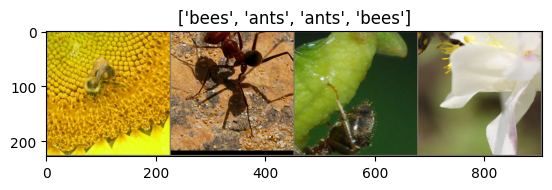

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training and evaluating the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.


The `train_model` function is designed to train and evaluate a given neural network model over a specified number of epochs.

## Parameters:

- **model**: The neural network model to be trained.
- **criterion**: The loss function.
- **optimizer**: The optimization algorithm.
- **scheduler**: Adjusts the learning rate based on the number of epochs.
- **num_epochs**: Number of times the model will be trained over the entire dataset (default is 25).

## Process:

1. **Time Tracking**:
    - The start time is recorded to calculate the total training time at the end.

2. **Temporary Directory for Checkpoints**:
    - A temporary directory is created to save the best model parameters during training.

3. **Training Loop**:
    - For each epoch:
        - The model is trained on the training dataset and evaluated on the validation dataset.
        - Depending on the phase (`train` or `val`), the model is set to the appropriate mode using `model.train()` or `model.eval()`.
        - The gradients are zeroed out at the beginning of each batch using `optimizer.zero_grad()`.
        - The model's predictions are compared to the actual labels to compute the loss.
        - If in the training phase, backpropagation is performed and the optimizer updates the model's parameters.
        - Running statistics like loss and accuracy are computed for each epoch.
        - If in the training phase, the learning rate scheduler adjusts the learning rate.
        - The best model (based on validation accuracy) is saved to the temporary directory.

4. **Results**:
    - After all epochs are completed, the total training time is printed.
    - The best validation accuracy achieved during training is also printed.

5. **Load Best Model**:
    - The best model parameters saved during training are loaded back into the model.

6. **Return**:
    - The trained model with the best parameters is returned.

By using this function, one can easily train and evaluate a neural network model, ensuring that the best version of the model (in terms of validation accuracy) is retained.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

The `visualize_model` function is designed to display predictions of the provided model on images from the validation dataset.

## Parameters:

- **model**: The trained neural network model whose predictions are to be visualized.
- **num_images**: The number of images on which predictions are to be displayed (default is 6).

## Process:

1. **Model State**:
    - The current training state of the model (either training or evaluation) is stored in the `was_training` variable.

2. **Set Model to Evaluation Mode**:
    - The model is set to evaluation mode using `model.eval()`. This ensures that operations like dropout are not applied during inference.

3. **Image Counter**:
    - `images_so_far` keeps track of the number of images processed.

4. **Visualization Setup**:
    - A new matplotlib figure is initialized to display the images and their predictions.

5. **Iterate Over Validation Data**:
    - The function iterates over batches of images from the validation dataset.
    - For each batch:
        - The images and labels are transferred to the appropriate device (either CPU or GPU).
        - The model makes predictions on the batch of images.
        - The predicted class indices are extracted using `torch.max`.

6. **Display Predictions**:
    - For each image in the batch:
        - A subplot is created for the image.
        - The image is displayed along with its predicted class label.
        - If the number of images displayed reaches `num_images`, the function returns.

7. **Restore Model State**:
    - Before exiting the function, the model's training state is restored to its original value using `model.train(mode=was_training)`.

By using this function, one can easily visualize the model's predictions on a subset of the validation dataset, providing a qualitative assessment of the model's performance.


In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer. More models are available at https://pytorch.org/vision/stable/models.html

In this section, we configure a ResNet-18 model for a binary classification task, set up the loss function, and define the optimizer and learning rate scheduler.

## Model Configuration (`model_ft`)

1. **Load Pre-trained ResNet-18**:
    - `models.resnet18(weights='IMAGENET1K_V1')`: Loads the ResNet-18 model pre-trained on the ImageNet dataset.

2. **Modify Fully Connected Layer**:
    - The final fully connected layer of ResNet-18 is modified to match the number of classes in our dataset.
    - `model_ft.fc.in_features`: Fetches the number of input features to the fully connected layer.
    - The output features of the fully connected layer are set to 2, indicating a binary classification task. Alternatively, this can be generalized to match the number of classes in the dataset.

3. **Transfer Model to Device**:
    - `model_ft.to(device)`: Moves the model to the specified device (either CPU or GPU).

## Loss Function (`criterion`)

- **CrossEntropyLoss (`nn.CrossEntropyLoss()`)**:
    - A commonly used loss function for classification tasks.
    - It combines the log softmax and negative log likelihood loss.

## Optimizer (`optimizer_ft`)

- **Stochastic Gradient Descent (SGD)**:
    - Parameters:
        - **model_ft.parameters()**: All the trainable parameters of the model.
        - **lr=0.001**: Learning rate.
        - **momentum=0.9**: Momentum factor.

## Learning Rate Scheduler (`exp_lr_scheduler`)

- **StepLR**:
    - Adjusts the learning rate based on the number of epochs.
    - Parameters:
        - **optimizer_ft**: The optimizer whose learning rate needs to be adjusted.
        - **step_size=7**: The learning rate is decayed every 7 epochs.
        - **gamma=0.1**: The factor by which the learning rate is decayed.

By setting up the model, loss function, optimizer, and learning rate scheduler as described, we are ready to train the model on our dataset.



In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.2MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6465 Acc: 0.6967
val Loss: 0.9628 Acc: 0.6400

Epoch 1/24
----------
train Loss: 0.6143 Acc: 0.7418
val Loss: 0.1880 Acc: 0.8800

Epoch 2/24
----------
train Loss: 0.6713 Acc: 0.6967
val Loss: 0.0401 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.4614 Acc: 0.8156
val Loss: 0.1498 Acc: 0.9600

Epoch 4/24
----------
train Loss: 0.5365 Acc: 0.8074
val Loss: 0.0797 Acc: 0.9600

Epoch 5/24
----------
train Loss: 0.4390 Acc: 0.8197
val Loss: 0.4907 Acc: 0.8000

Epoch 6/24
----------
train Loss: 0.5399 Acc: 0.7869
val Loss: 0.9866 Acc: 0.6000

Epoch 7/24
----------
train Loss: 0.3248 Acc: 0.8607
val Loss: 0.5082 Acc: 0.8000

Epoch 8/24
----------
train Loss: 0.4401 Acc: 0.8279
val Loss: 0.2419 Acc: 0.9200

Epoch 9/24
----------
train Loss: 0.3014 Acc: 0.8525
val Loss: 0.1770 Acc: 0.8800

Epoch 10/24
----------
train Loss: 0.2945 Acc: 0.8852
val Loss: 0.1732 Acc: 0.9200

Epoch 11/24
----------
train Loss: 0.2835 Acc: 0.8648
val Loss: 0.1524 Acc: 0.9600

Ep

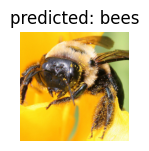

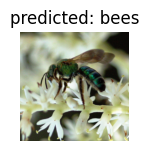

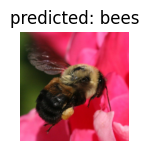

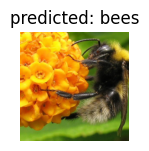

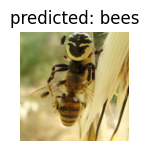

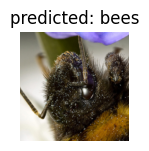

In [11]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5553 Acc: 0.7377
val Loss: 0.4190 Acc: 0.8800

Epoch 1/24
----------
train Loss: 0.7480 Acc: 0.6803
val Loss: 0.2792 Acc: 0.9200

Epoch 2/24
----------
train Loss: 0.5064 Acc: 0.7828
val Loss: 0.0390 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.4827 Acc: 0.7951
val Loss: 0.1530 Acc: 0.9200

Epoch 4/24
----------
train Loss: 0.3358 Acc: 0.8689
val Loss: 0.3005 Acc: 0.9200

Epoch 5/24
----------
train Loss: 0.5898 Acc: 0.7254
val Loss: 0.2984 Acc: 0.9200

Epoch 6/24
----------
train Loss: 0.4937 Acc: 0.8033
val Loss: 0.2157 Acc: 0.8800

Epoch 7/24
----------
train Loss: 0.3837 Acc: 0.8279
val Loss: 0.3447 Acc: 0.8800

Epoch 8/24
----------
train Loss: 0.4115 Acc: 0.8320
val Loss: 0.3415 Acc: 0.8800

Epoch 9/24
----------
train Loss: 0.2309 Acc: 0.8934
val Loss: 0.2303 Acc: 0.9200

Epoch 10/24
----------
train Loss: 0.3942 Acc: 0.7992
val Loss: 0.3349 Acc: 0.8800

Epoch 11/24
----------
train Loss: 0.4427 Acc: 0.8238
val Loss: 0.3691 Acc: 0.8800

Ep

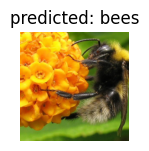

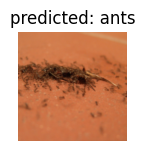

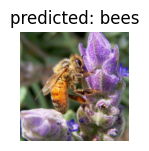

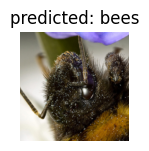

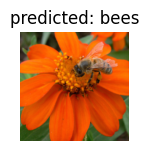

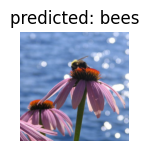

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

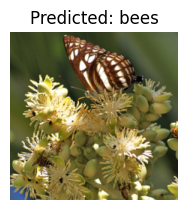

In [17]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()